### Imports

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

from ShortCutAgents import QLearningAgent, SARSAAgent, ExpectedSARSAAgent, nStepSARSAAgent
from ShortCutEnvironment import ShortcutEnvironment, WindyShortcutEnvironment

___
### Repetitions
Each repetition, regardless of agent or environment, does the same steps of initializing then training and therefore one function can run for all.

In [17]:
def run_repetitions(agent_type, env_type, n_rep=100, n_episodes=1000, e=0.1, a=0.1, g=1, **args) -> np.array:
    """
    Run repetitions of agent initialization and training to obtain the average expected reward for each episode.
    Also prints the greedy policy of the agent in the console.

    :param agent_type: The agent class used for repetitions.
    :param env_type: The environment class in which the agent behaves.
    :param n_rep: Number of repetitions for the experiment to run.
    :param n_episodes: Number of training episodes for the agent to run.
    :param e: Epsilon hyperparameter to be used by agent.
    :param a: Alpha hyperparameter to be used by agent.
    :param g: Gamma hyperparameter to be used by agent.
    :param args: Can accept n_steps (int) hyperparameter, or seed (int) hyperparameter.

    :return: The rewards of each episode averaged over all repetitions
    """

    # Prevent no environment and agent initialization
    if n_rep < 1:
        return np.array([0])

    # Get the average rewards for given hyper-parameters
    total_rewards = np.zeros([n_rep, n_episodes])
    for rep in range(n_rep):
        env = env_type()
        agent = agent_type(env, epsilon=e, alpha=a, gamma=g, **args)
        total_rewards[rep] = agent.train(n_episodes)

    # Print an example of the greedy policy for one iteration, then return
    print("Greedy policy for", agent_type.__name__, "in a", env_type.__name__)
    # # Add print for parameters
    env.render_greedy(agent.Q)
    smooth_rewards = savgol_filter(total_rewards, 38, 1)
    return np.mean(smooth_rewards, axis=0)

___
### Helper functions
Functions of graphing and running individual experiments to make code easier to read and less prone to bugs.

In [18]:
def graph(curve: np.typing.ArrayLike, label: str, title: str = None, x_label="Episodes", y_label="Average reward"):
    """
    Plots a graph using a set of curve points and adds it to the legend, can also be used to set up a figure.

    :param curve: Curve points to plot as a graph
    :param label: The graph label to add as legend
    :param title: Set the new figure title
    :param x_label: Set the new figure x-axis label
    :param y_label: Set the new figure y-axis label
    """

    # New figure setting
    if title is not None:
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
    # Plot the graph and add the legend
    plt.plot(curve, label=label)
    plt.legend(loc='lower right')


def complete_run(agent, env, avg_rewards: list, var: str, val: float, all_rewards: list, all_labels: list, **args):
    """
    Saves the run results and outputs the run results figure.

    :param agent: Agent of the run experiment.
    :param env: Environment of the agent.
    :param avg_rewards: Averaged results from multiple repetitions.
    :param var: Name of experimented variable for printing.
    :param val: Value of experimented variable for printing.
    :param all_rewards: List containing all current set-up saved results, modified by reference.
    :param all_labels: List containing all cuurent set-up saved labels, modified by reference.
    """
    
    # Save results
    all_rewards.append(avg_rewards)
    all_labels.append(f"{agent.__name__} in {env.__name__}, {var}={val}")
    # Present results of this specific experiment alone
    plt.figure()
    graph(avg_rewards, f"{var}: {val}", f"{agent.__name__} in {env.__name__}")

___
### Experiment code

In [19]:
def experiment(alpha: list = None, n: list = None, agent_types: list = None, env_types: list = None, seed: int = None, **args):
    """
    By default, runs all the report required experiments and presents the results for every desired figure.
    Can be used to run specific experiments on alpha values.

    :param default: Runs default experiment
    :param alpha: All alpha float values to be tested
    :param n: All n step values to be tested
    :param agent_types: All agent classes
    :param env_types: All environmental classes
    :param seed: Randomization setting
    :param args: Arguments to be passed to the repetitions
    """

    # Allow for recreation if desired
    if seed is not None:
        np.random.seed(seed)

    # Default alpha and n-step experiment ranges
    if alpha is None:
        alpha = [0.01, 0.1, 0.5, 0.9]
    if n is None:
        n = [1, 2, 5, 10, 25]

    # By default use all agents and environments
    if agent_types is None:
        agent_types = [QLearningAgent, SARSAAgent, ExpectedSARSAAgent, nStepSARSAAgent]
    if env_types is None:
        env_types = [ShortcutEnvironment, WindyShortcutEnvironment]

    # Run repetitions and present immediate results
    for agent in agent_types:
        for env in env_types:
            # Save all results to present later together
            all_rewards = []
            all_labels = []
            # Windy environment only for SARSAAgent
            if agent is not SARSAAgent and env is WindyShortcutEnvironment:
                continue
            # Don't test alpha for nStepsSARSAAgent, test n_steps instead
            if agent is not nStepSARSAAgent:
                for a in alpha:
                    avg_rewards = run_repetitions(agent, env, a=a, **args)
                    complete_run(agent, env, avg_rewards, "Alpha", a, all_rewards, all_labels)
            else:
                for steps in n:
                    avg_rewards = run_repetitions(agent, env, a=0.5, n_steps=steps, **args)
                    complete_run(agent, env, avg_rewards, "Steps", steps, all_rewards, all_labels)

            # Show all results of environment in one figure
            plt.figure()
            for curve, label in zip(all_rewards, all_labels):
                graph(curve, label, "Results of all experiment variations")
            plt.show()

___
### Run the different experiments
Individual tests to make viewing easier.

Greedy policy for QLearningAgent in a ShortcutEnvironment
→ ↓ ↓ ← ↑ ↑ ↓ → → ↑ → ↓
→ ← ← ↑ → ↑ → ↓ ↑ → ↓ ↓
← ↓ ↑ ↓ ↑ → ← → ↑ ↓ ↓ →
← ↑ ↑ ↑ → ↑ ↑ ← → ↑ ↓ ↑
← → ↓ ↑ C C C C ↑ ← ↓ ↓
↓ → ↑ ↑ C C C C ↓ ↑ → →
→ ← ← ← C C C C ↓ ← → ↓
↓ ← ↑ ← C C C C 0 → ↓ ←
← ← ← ↓ C C → 0 G 0 ← ←
→ ↓ ← → → → ↑ C 0 ← ↓ ↑
→ ↑ ↓ ← C C C C → ← ← ↓
← ↓ ↓ ↓ C C C C ↓ ↓ ↑ ↓

Greedy policy for QLearningAgent in a ShortcutEnvironment
→ ↑ ← ← ← → ↑ → → → ↓ ↑
↑ ↑ → ↑ ← → → ↓ ↓ ↑ ↑ ↓
← ← ↓ → → → ↓ → ↓ ↓ ↓ ←
↓ ↑ → → → → → → ↓ ↓ ← ↑
← ↑ → ↓ C C C C ↓ ← ↓ ↑
↓ ← ↓ ↓ C C C C ↓ ↓ ↓ →
→ ← ↓ ↓ C C C C ↓ ↓ ← ↓
← → → ↓ C C C C 0 ← ← →
↓ ← ↓ ↓ C C → 0 G 0 → ↓
← → → → → → ↑ C 0 → ↓ →
← ← ↑ ↑ C C C C ↓ ↑ ← →
→ ← → ↑ C C C C ↑ ← ← ←

Greedy policy for QLearningAgent in a ShortcutEnvironment
→ ↓ ← → → → → → ↓ ↓ ↑ ↑
→ ↑ ↓ → → ↓ → ↓ ↓ ↓ ↓ ↑
↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ → ↑ ↓
↓ ↓ → → → → → → ↓ ← ← →
↓ ↓ ↓ ↓ C C C C ↓ ↓ → →
↓ ↓ ↓ ↓ C C C C ↓ ↓ ← ↑
↓ ↓ ↓ ↓ C C C C ↓ ↓ ↓ ↓
← → ↓ ↓ C C C C 0 ↓ ← ←
↓ → ↓ ↓ C C → 0 G 0 ← ←
→ → → → → → ↑ C 0 ↓ ↑ ↓
← ↑ ↑ ↑ 

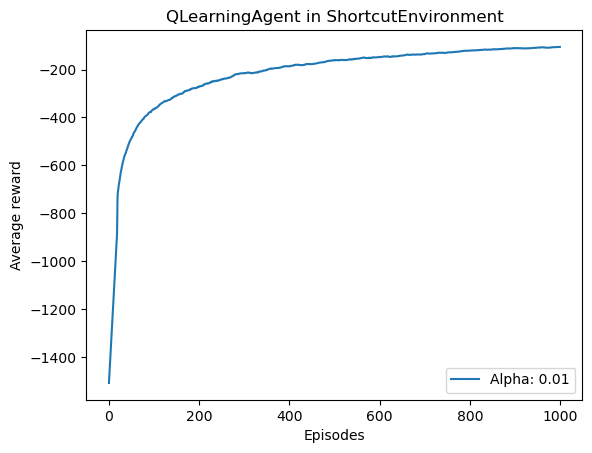

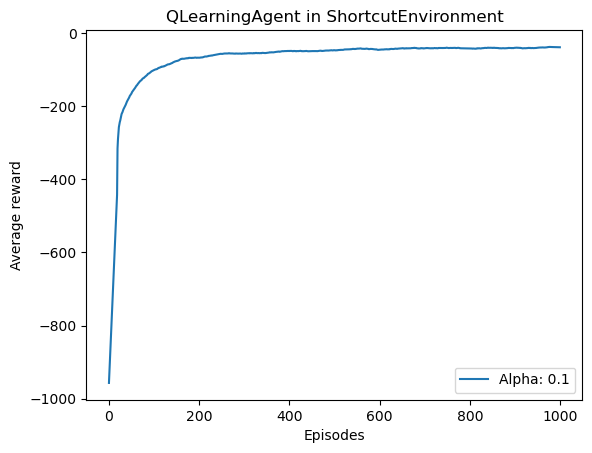

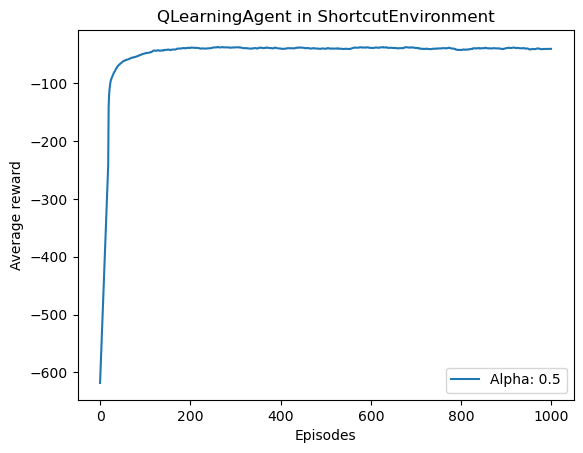

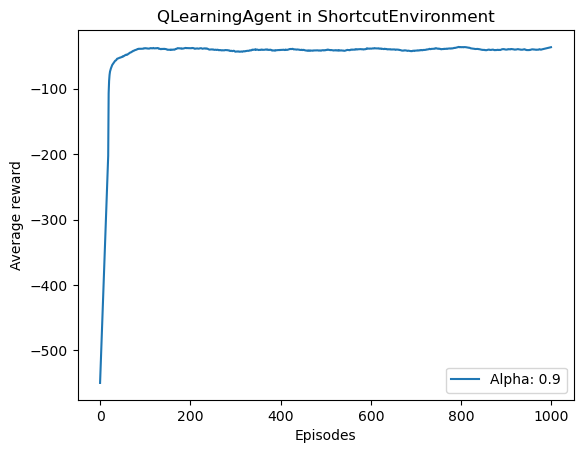

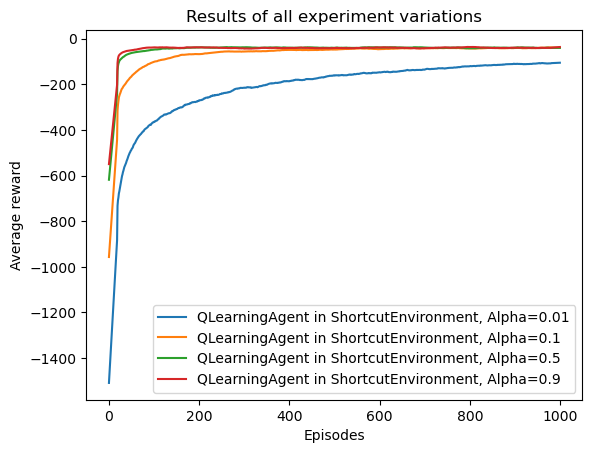

In [20]:
# QLearningAgent
experiment(n=[], agent_types=[QLearningAgent], env_types=[ShortcutEnvironment])

Greedy policy for SARSAAgent in a ShortcutEnvironment
→ → → ↑ ← → ↑ → ← ↑ → ↑
→ ↑ → ↑ ← ↓ → → ↑ ↓ ↑ →
→ → ↑ → → → → → ← → ↓ ←
↓ ← ↑ ↓ ↑ ← ↑ → ↓ → ↓ ←
↑ → ← ↓ C C C C ↓ → ↓ ←
→ → ↑ ↓ C C C C ↓ → ↓ ↑
→ ← ↑ ← C C C C ↓ ← → ←
→ ← ↓ ↑ C C C C 0 → ↓ ↓
→ ↓ ↑ ↓ C C → 0 G 0 ↑ ←
↓ ← ↑ ← → → ↑ C 0 → → ↓
→ ↓ ↑ ↑ C C C C → ↓ ↓ ↑
↓ → ↑ ← C C C C → ← ↑ ←

Greedy policy for SARSAAgent in a ShortcutEnvironment
↑ ↑ → ↓ → ← → → ↓ ↓ ↑ ←
→ ↓ → → → ↓ → → → ↓ ↓ ←
→ → → → → → → → → ↓ ↓ ↓
→ ↑ → ↑ ↑ ↑ ↑ ↑ → ↓ ↓ ↓
← → ↑ ↓ C C C C → ↓ ↓ ↓
↑ ↑ ↑ ↓ C C C C → ↓ ↓ ↓
↑ ↑ ↑ ↑ C C C C ↓ ↓ ↓ ↓
↑ ← ↑ ↑ C C C C 0 ↓ ↓ →
↑ ↑ ↑ ↑ C C → 0 G 0 ← ←
→ ↑ ↓ ↑ → → ↑ C 0 → ← ←
↓ ↓ ↓ ↑ C C C C ↑ → ↑ ↓
← ← ↑ ← C C C C → ← ↓ ↓

Greedy policy for SARSAAgent in a ShortcutEnvironment
→ ↑ → → → ↓ ↓ → ↓ → → ↓
→ → → → → → → ↓ → ↓ → ↓
↑ → ↑ ↑ ↑ ↓ ↑ → → ↓ → ↓
→ ↑ ↑ ← ← ↑ ↑ → → ↓ ↓ ↓
↑ ↑ ↑ ↓ C C C C → → ↓ ↓
↑ ↑ ← ← C C C C ↓ → → ↓
↑ ← ↑ ↓ C C C C ↓ → ↓ ↓
↑ ↑ ↑ ← C C C C 0 ↓ ↓ ←
↑ ↑ ↑ ← C C → 0 G 0 ← ↓
↑ ↑ ↑ ← ← ← ← C 0 ↑ ← ←
↓ ← ↑ ↓ C C C C ↑ ← 

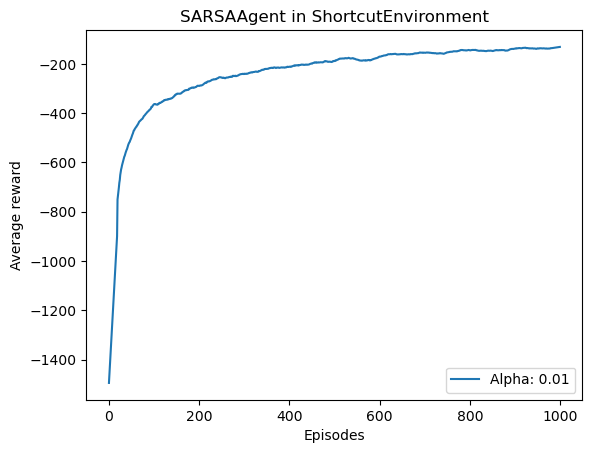

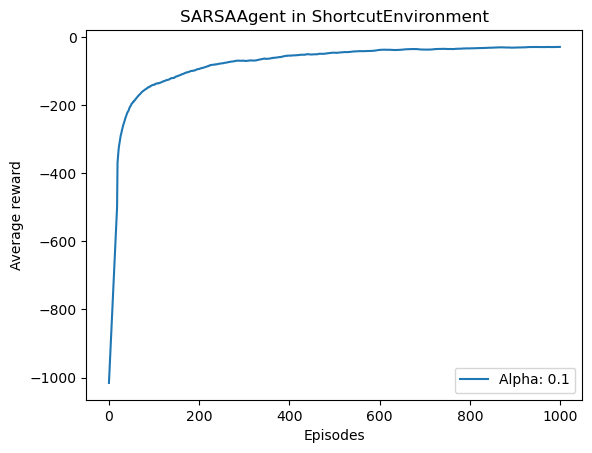

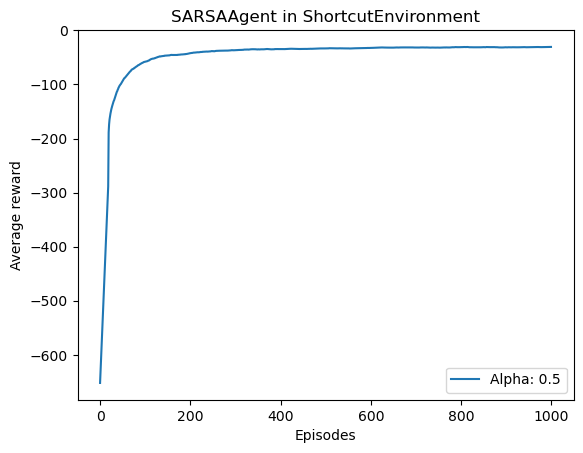

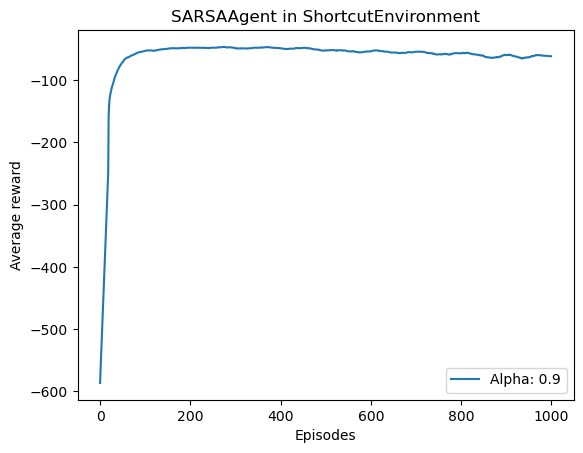

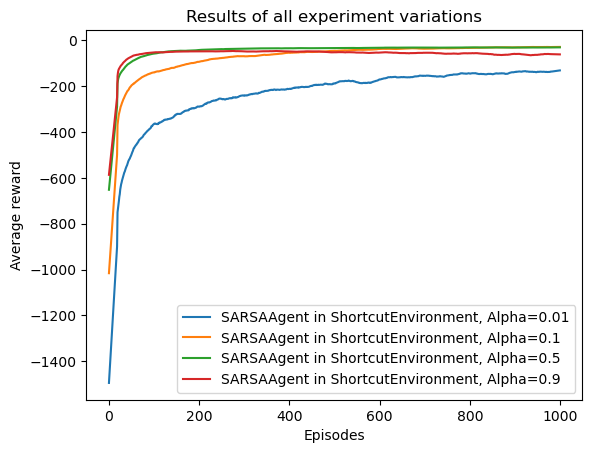

Greedy policy for SARSAAgent in a WindyShortcutEnvironment
↑ → → → → → → → → → ↑ ↑
↑ → → ↑ ↑ ↑ ← ↓ ↓ ← ↑ ↑
↑ → → ↑ ↑ ← → → ↓ ↑ ↓ ↑
↑ ↑ ↑ ← ↑ ↑ ↑ ↑ ↓ ↑ ↑ ↑
↓ ↑ ↓ ↑ C C C C ↓ → ↑ ←
→ ↑ ↑ ↑ C C C C ↓ ← ↑ ←
↑ ↑ ↑ ↑ C C C C ↑ ← ← ↑
↑ ↑ ↑ ↑ C C C C → ← ↑ ↑
↑ ↑ ↑ ← C C ← ← G ↑ ↑ →
↑ ↑ ↑ ← → ↑ ↑ C ↑ ↑ ↑ ←
↑ ↑ → ← C C C C → → ↑ ↑
← → ↑ ← C C C C ↑ → ↓ ↑

Greedy policy for SARSAAgent in a WindyShortcutEnvironment
↑ ↓ → → → → → → → → → ↓
↓ ← ↑ ↑ ↑ ↑ ↑ → → → ← ↑
↑ ↑ ← → → ↑ → → → → ← →
↑ ↑ ↑ ↑ ↑ ↑ ↑ → → ↑ ↓ ←
↓ ↑ ↑ ← C C C C ↓ ↑ ← ↑
↑ ↓ ← ← C C C C ↓ → → ↑
↑ ↑ ← ↑ C C C C ↓ ↑ → ↓
↑ ↑ ↑ ← C C C C → ← ↓ →
↑ ↑ ↑ ← C C 0 ← G ↓ ↑ ↑
↑ ↑ ↑ ↑ ← 0 0 C ↓ ↑ ← ←
↑ ↑ ↑ ↓ C C C C ↑ ↓ → ←
↑ ↑ ↑ ↓ C C C C → ↑ → ↑

Greedy policy for SARSAAgent in a WindyShortcutEnvironment
↑ ↓ → ← → → ↓ ↑ → ↑ → →
→ → → ↑ → → → → ↑ ↓ ↑ ↑
↑ ↑ ↑ ↑ ↑ ↑ ↑ → → → → ↑
→ ↑ ↑ ← ← ↑ ↑ ↑ ↓ → ↑ ←
↑ ↑ ↑ ↑ C C C C ↓ ↑ → ←
↑ ↓ ↑ ↑ C C C C → ↑ ↑ ←
↑ ↑ ↑ ← C C C C ↓ → ← ↓
↑ ↑ ← ↓ C C C C ↑ ← ← ↑
↑ ← ← ← C C → ← G ↑ ↑ ↑
↑ ↑ ↑ ↑ ← ← ← C ↑ ← ↑ ←
↑ ↑ ↑

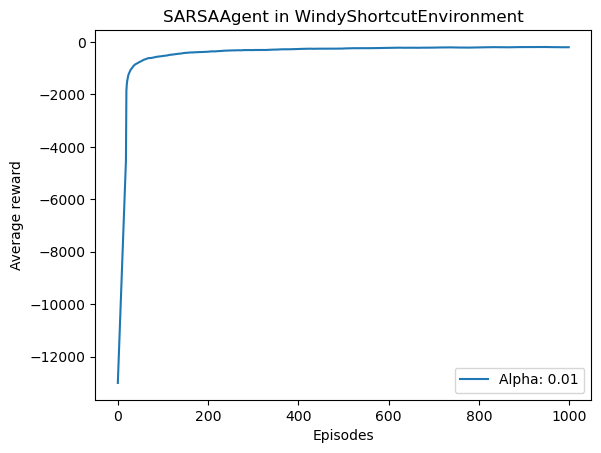

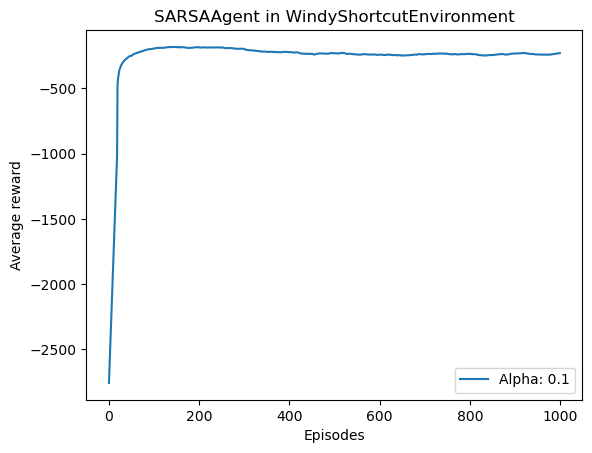

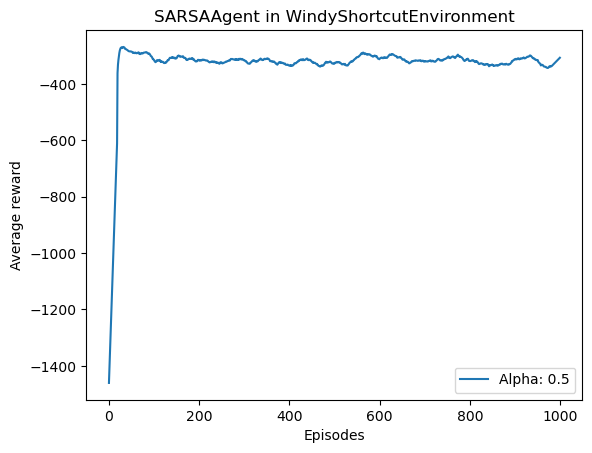

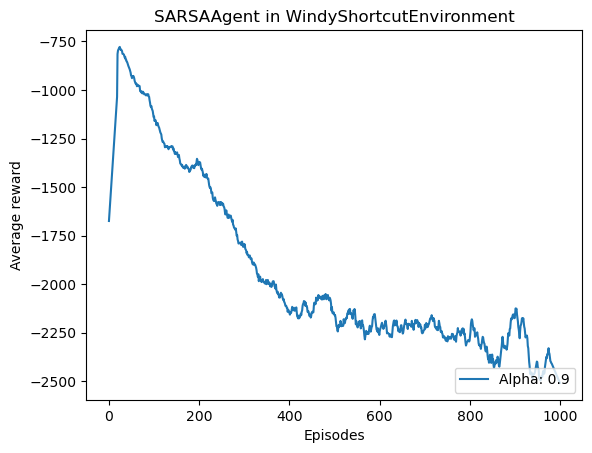

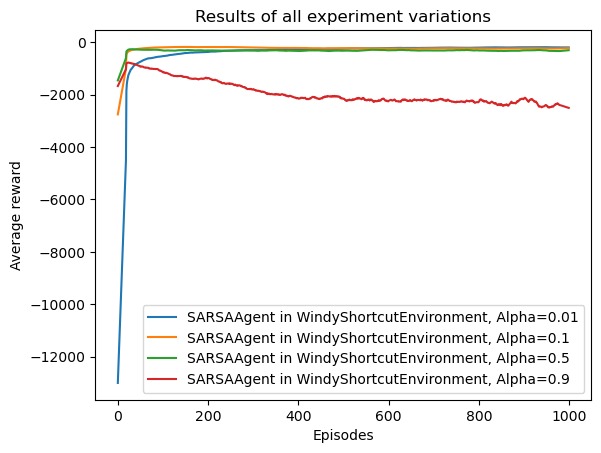

In [21]:
# SARSAAgent
experiment(n=[], agent_types=[SARSAAgent], env_types=[ShortcutEnvironment, WindyShortcutEnvironment])

Greedy policy for ExpectedSARSAAgent in a ShortcutEnvironment
↑ → ↓ → → ↓ ↑ → ↓ ↑ ↑ ←
← ← ↑ → ← ↑ ← ↓ ← ↑ ↓ ←
← ↑ ↑ → ↓ ↓ ↑ ← ↓ → ↓ →
↓ → ↑ ↓ → ← ← ↑ ↑ ↓ → ←
← ↑ → ↑ C C C C ↓ ↓ → ←
↑ ↑ ↑ ↑ C C C C ↓ ↓ ← ←
→ ↑ ↓ ← C C C C ↓ ↓ ← ←
↓ → ↓ ↓ C C C C 0 ↓ ↓ ↓
↑ → → ↑ C C → 0 G 0 ← →
↑ ← ↑ → → → ↑ C 0 → ← ←
→ ↓ → ↓ C C C C ↓ → ↑ ↓
← ↓ ↓ ← C C C C ↓ ↓ → ↓

Greedy policy for ExpectedSARSAAgent in a ShortcutEnvironment
→ ↑ ↓ → ↓ → → → → ↓ → →
→ → → → → → → ↓ → ↓ ↓ ↑
↑ → → → → → → → ↓ ↓ ↓ ←
→ ↑ → ↑ ↑ ← → → → ↓ → ↑
↓ ↑ ↑ ← C C C C ↓ ↓ ↓ ↓
→ ↑ ↑ ← C C C C → ↓ ↓ ↓
← → ↑ ↑ C C C C → ↓ ↓ ↓
↑ ↓ ↑ ↓ C C C C 0 ↓ ↓ ↓
→ ↑ ↑ ↑ C C → 0 G 0 ← →
↑ ↑ ↓ ← → → ← C 0 ↓ ↑ ↓
↑ ↓ ↓ ↓ C C C C ↑ → ↑ ↑
→ → ↓ ↓ C C C C ↓ ← ↓ ↓

Greedy policy for ExpectedSARSAAgent in a ShortcutEnvironment
↑ ← → → → → → → ↓ → → ↓
↓ → → → → → → → → ↓ ↓ ↓
↑ ↑ ↑ ↑ → ↑ ↑ → ↓ ↓ ↓ ↓
↓ → ↑ ↑ ↑ → ← → → ↓ ↓ ↓
↑ ↑ ↑ ↑ C C C C ↑ → ↓ ↓
→ ↑ ↑ ← C C C C → ↓ ↓ ↓
↑ → ↑ ← C C C C ↓ ↓ ↓ ↓
← ↑ ↑ ↓ C C C C 0 ↓ ↓ ←
↑ ↑ ← ↑ C C 0 0 G 0 ← ←
↑ ↑ ← ← ← → 0 C 0 ↑ 

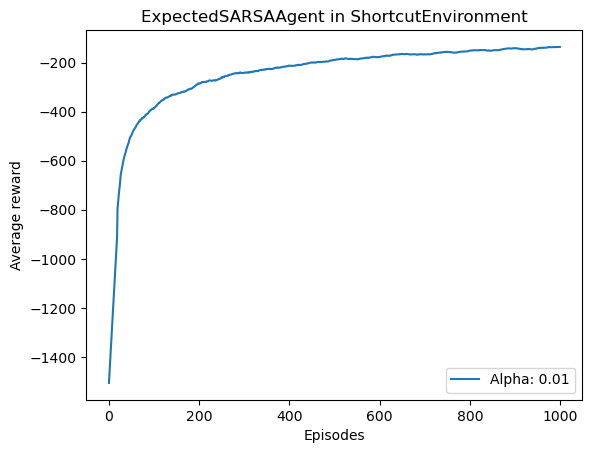

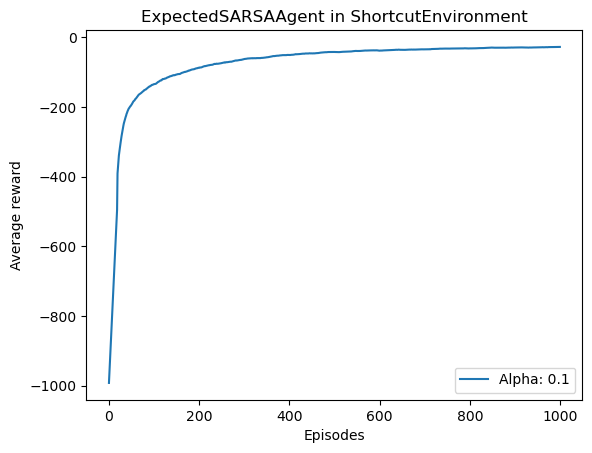

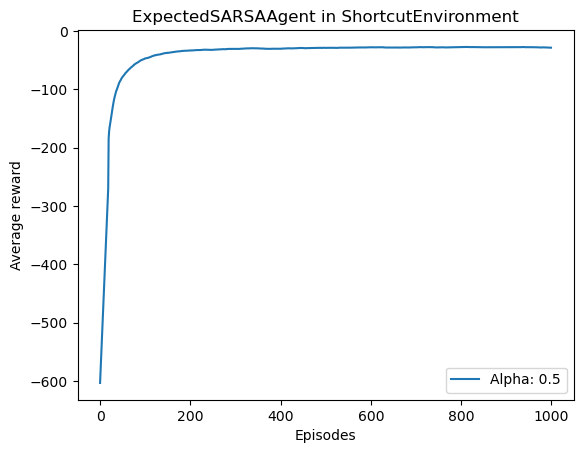

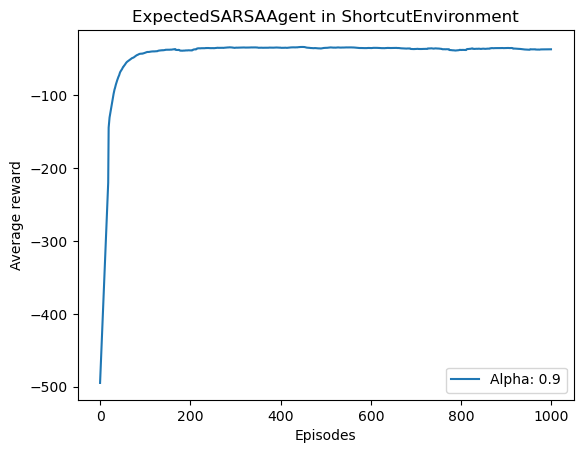

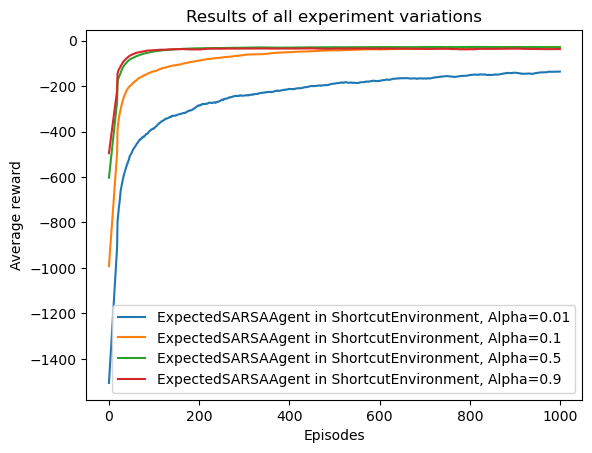

In [22]:
# ExpectedSARSAAgent
experiment(n=[], agent_types=[ExpectedSARSAAgent], env_types=[ShortcutEnvironment])

Greedy policy for nStepSARSAAgent in a ShortcutEnvironment
← ← ← ↑ ← ↓ → → ↓ → → ←
↓ → ↓ → → → → ↑ ↓ ↑ → ←
← ← → ↑ ← ← → ↓ → ← ↓ ↓
→ ↑ ↑ → ↓ ↓ ↓ → ↑ ↓ → ↓
↑ ↑ ↑ ↑ C C C C → ↓ ↓ ↓
↑ ← ← ← C C C C → ↓ ← ←
← ↑ → ↑ C C C C → ↓ ↓ ←
→ ↑ ↑ → C C C C → ↓ → ←
↑ ← ↓ → C C 0 0 G ← → →
↑ ↓ ← ← → → 0 C → ↓ ↓ ↓
← → ↑ ← C C C C ↓ ↑ ↑ ↓
← → ← → C C C C ↓ → ↓ ←

Greedy policy for nStepSARSAAgent in a ShortcutEnvironment
← ↓ ↑ → ↓ ↓ → ↓ ← ↓ → ↓
→ → → ↑ ↓ → → → → ↓ → ↑
↓ → ↑ ↑ → ↑ ← ↑ ↑ → ↓ →
→ ↑ ← → ↑ ↑ → → ↓ ↑ → ↓
→ ↑ ↑ ↑ C C C C → ↑ ↓ ↓
↑ ↑ ← ↓ C C C C ← → ← ↓
← ↑ ← → C C C C ← → ↓ ←
↓ ↑ ← → C C C C ← ↓ ← ←
↑ ↑ ↑ ↓ C C 0 0 G ← ← →
← ↑ ↓ → ↑ ← 0 C ↑ ← ← ←
← ↑ ← → C C C C → ↑ → ↑
↓ ← ← ← C C C C ← → ← ↑

Greedy policy for nStepSARSAAgent in a ShortcutEnvironment
→ ↓ → → → → → ↓ → ↓ ↓ ←
↓ → ← ↑ ← ↑ ↑ ↓ ↑ ↓ ← ↓
↑ ↑ ↓ → → → ↑ → ↑ → ↓ ↓
→ ↓ ↑ ↑ ↓ ↓ → ↑ → ↑ → ↓
↑ ↓ ↑ ↑ C C C C ← ↑ ↑ ↓
↑ → ↑ ↑ C C C C ↑ ↑ ↓ ↓
→ ↑ ← ← C C C C → ↑ ↓ ↓
↓ ↑ ↓ → C C C C → → ↓ ←
↑ ← ← → C C 0 0 G ← ← ↓
← ← ↑ → ↑ ← 0 C ↓ ↑ ↑ ←
↑ ↑ ↑

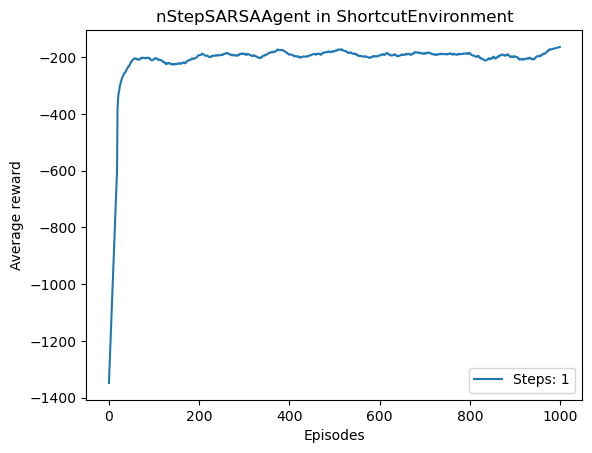

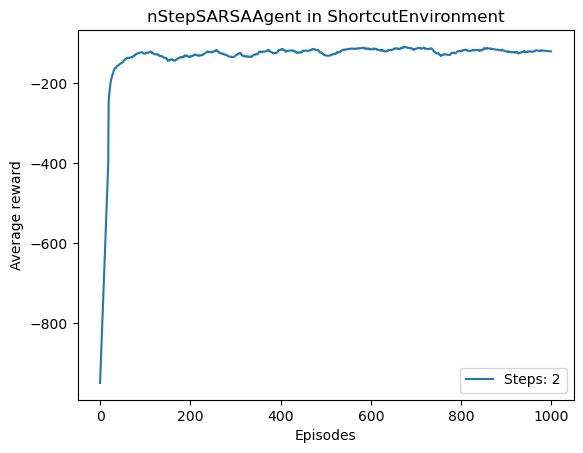

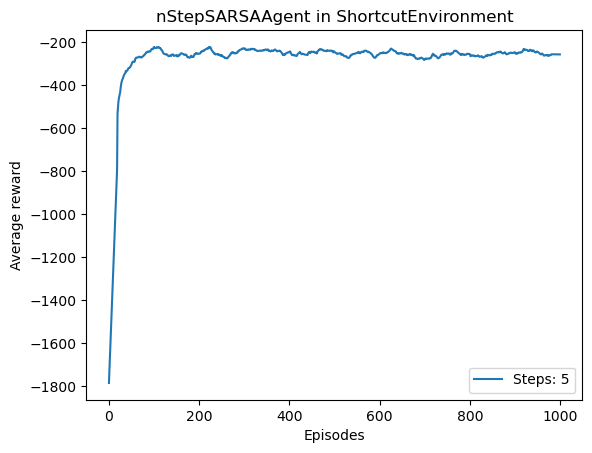

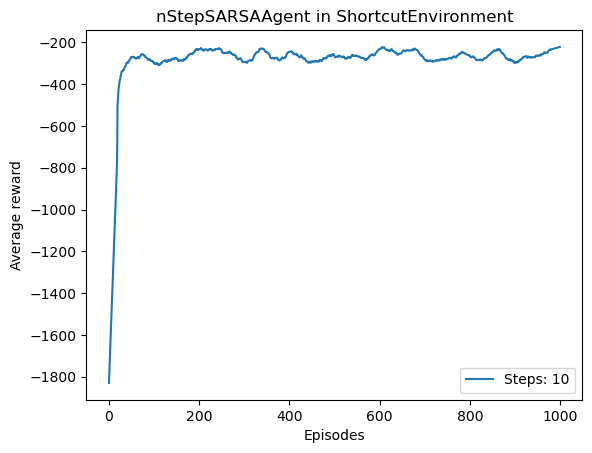

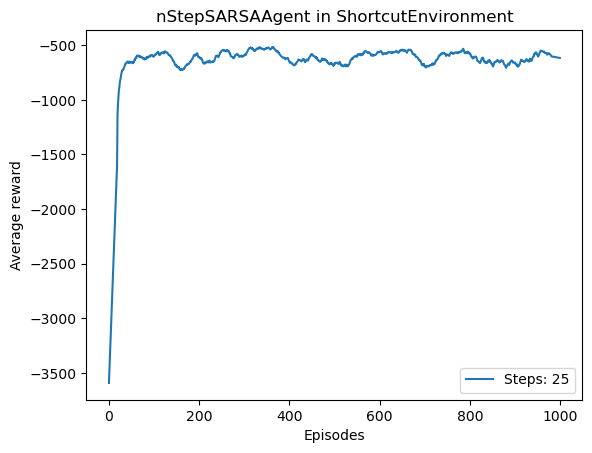

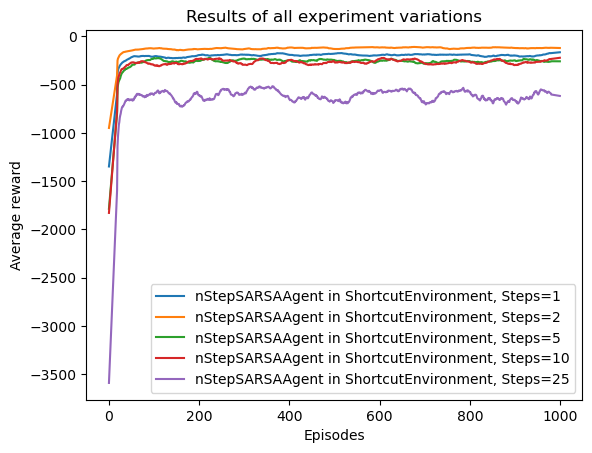

In [23]:
# nStepsSARSAAgent
experiment(alpha=[], agent_types=[nStepSARSAAgent], env_types=[ShortcutEnvironment])